In [770]:
import pandas as pd
import json
import pickle

# 1. Charger le fichier Excel
df = pd.read_excel(r"C:\Users\harri\Downloads\SheetCode.xlsx")

# 2. Nettoyer les noms de colonnes
df.columns = df.columns.str.strip()

# 3. Dictionnaire final
final_dict = {}

# 4. Itérer sur les colonnes deux par deux
columns = list(df.columns)
i = 0
while i < len(columns) - 1:
    key_col = columns[i]
    val_col = columns[i + 1]

    # Vérifier que la 2e colonne contient bien des chiffres
    if pd.api.types.is_numeric_dtype(df[val_col]):
        # Extraire les deux colonnes sans NaN
        temp_df = df[[key_col, val_col]].dropna()

        # Construire dictionnaire inversé (clé = int, valeur = str)
        sub_dict = dict(zip(temp_df[val_col].astype(int), temp_df[key_col].astype(str).str.strip()))

        # Ajouter à la grande clé (ex : "Types of salt")
        final_dict[key_col] = sub_dict

        i += 2  # passer au couple suivant
    else:
        i += 1  # avancer d'une colonne

# 5. Sauvegarde en JSON (clés numériques deviendront chaînes)
with open("structured_output_inverted.json", "w", encoding="utf-8") as f_json:
    json.dump(final_dict, f_json, indent=2, ensure_ascii=False)

# 6. Sauvegarde en Pickle (conserve les clés en int)
with open("structured_output_inverted.pkl", "wb") as f_pkl:
    pickle.dump(final_dict, f_pkl)

print("✅ JSON et Pickle sauvegardés avec succès !")
print("📄 structured_output_inverted.json  → pour usage général")
print("📦 structured_output_inverted.pkl   → pour usage Python avec clés numériques")


✅ JSON et Pickle sauvegardés avec succès !
📄 structured_output_inverted.json  → pour usage général
📦 structured_output_inverted.pkl   → pour usage Python avec clés numériques


In [771]:
import pickle
import pprint  # pour un affichage lisible

# 1. Charger le fichier pickle
with open("structured_output_inverted.pkl", "rb") as f:
    data = pickle.load(f)

# 2. Afficher proprement le contenu
print("✅ Fichier Pickle chargé avec succès.\n")
pprint.pprint(data)


✅ Fichier Pickle chargé avec succès.

{'Additives': {0: 'No additive',
               1: 'Sugars',
               2: 'Gum or hydrocolloids',
               3: 'Starch',
               4: 'Fibre',
               5: 'Mineral',
               6: 'salt',
               7: 'Phenolic compound',
               8: 'Amino acids',
               9: 'Others',
               101: 'Monosaccharides',
               102: 'Disaccharides',
               201: 'Plant',
               202: 'Microbial',
               203: 'seaweed',
               204: 'animal or insects',
               301: 'Native starch',
               302: 'Modified starch',
               401: 'Plant based fibres',
               402: 'Other based fibres',
               501: 'Metallic',
               701: 'Natural',
               702: 'Synthetic',
               801: 'Charged',
               802: 'Uncharged',
               901: 'Acids',
               902: 'Base',
               903: 'oils or fats',
               904: 'Other

In [858]:
import pandas as pd
import pickle
from difflib import get_close_matches

# 1. Charger le pickle
with open("structured_output_inverted.pkl", "rb") as f:
    mappings = pickle.load(f)
print("✅ Fichier Pickle chargé avec succès.\n")

# 2. Charger le DataFrame
df = pd.read_csv(
    r"C:\Users\harri\ai_bobby_repository\data\raw\Hardness.csv",
    sep=None,
    engine='python',
    encoding='utf-8-sig'
)
df.columns = df.columns.str.strip()

# 3. Copie de travail
df_transformed = df.copy()
df_transformed.columns = df_transformed.columns.str.strip()

# 4. Supprimer colonnes inutiles
columns_to_drop = ['Citation', 'Citation Link', 'Protein', 'Unnamed: 21']
cols_removed = [col for col in columns_to_drop if col in df_transformed.columns]
df_transformed.drop(columns=cols_removed, inplace=True)
print(f"🗑️ Colonnes supprimées : {cols_removed}")

# 5. Convertir Additives en float si présente
if 'Additives' in df_transformed.columns:
    try:
        df_transformed['Additives'] = pd.to_numeric(df_transformed['Additives'], errors='coerce')
        print("🔢 'Additives' convertie en float.")
    except Exception as e:
        print(f"❌ Erreur de conversion 'Additives' : {e}")

# 6. Mapping manuel
manual_mapping = {
    "If gel is formed": "If a gel can be formed (0-1)",
    "Types of salt": "Type of salt",
}

# 7. Stockage des valeurs non mappées
unmapped_global = []

# 8. Remplacement via pickle
for main_key, value_map in mappings.items():
    if main_key in manual_mapping:
        matched_col = manual_mapping[main_key]
        print(f"🔁 Clé '{main_key}' mappée manuellement à '{matched_col}'")
    else:
        close_matches = get_close_matches(main_key, df_transformed.columns, n=1, cutoff=0.6)
        matched_col = close_matches[0] if close_matches else None

    if matched_col and matched_col in df_transformed.columns:
        print(f"✅ Traitement de la colonne : '{matched_col}'")
        original_values = df_transformed[matched_col]
        replaced_values = original_values.apply(lambda x: value_map.get(x, x))
        df_transformed[matched_col] = replaced_values

        changed_mask = (original_values != replaced_values) & (~pd.isna(replaced_values))
        changed_rows = df_transformed.loc[changed_mask, [matched_col]]
        if not changed_rows.empty:
            print(f"\n🔄 Valeurs remplacées dans '{matched_col}':")
            print(changed_rows.head(5))

        unmapped_mask = ~original_values.isin(value_map.keys())
        unmapped_rows = df.loc[unmapped_mask, [matched_col]].dropna().drop_duplicates()
        if not unmapped_rows.empty:
            print(f"\n❓ Non mappés dans '{matched_col}':")
            print(unmapped_rows.head(5))
            unmapped_rows["Unmapped column"] = matched_col
            unmapped_global.append(unmapped_rows)
    else:
        print(f"❌ Aucune colonne trouvée pour la clé '{main_key}'")

# 9. 🔍 Conversion automatique des colonnes à virgule ou chiffres en float
print("\n🔍 Conversion des colonnes avec nombres (virgule ou entiers) :\n")
for col in df_transformed.columns:
    if df_transformed[col].dtype == "object":
        values = df_transformed[col].dropna().astype(str)
        ratio_comma_decimal = values.str.match(r"^\d+,\d+$").mean()
        ratio_digit = values.str.match(r"^\d+$").mean()
        if ratio_comma_decimal > 0.3:
            print(f"➡️  {col} : détecté comme nombre à virgule (ratio = {ratio_comma_decimal:.2f})")
            df_transformed[col] = values.str.replace(",", ".", regex=False)
            df_transformed[col] = pd.to_numeric(df_transformed[col], errors="coerce")
            print(f"   ✅ Convertie en float")
        elif ratio_digit > 0.3:
            print(f"➡️  {col} : détecté comme entier numérique (ratio = {ratio_digit:.2f})")
            df_transformed[col] = pd.to_numeric(values, errors="coerce")
            print(f"   ✅ Convertie en float")

# 10. Remplacement des valeurs manquantes dans les colonnes object par 'unused' + colonne is_present
print("\n♻️ Remplacement des valeurs manquantes textuelles par 'unused' + ajout colonne is_present :")
missing_equivalents = ["No special treatment", "No additive", "No salt"]
for col in df_transformed.select_dtypes(include='object').columns:
    before = df_transformed[col].isna().sum()
    is_present_col = f"is_present_{col}"
    df_transformed[is_present_col] = ~df_transformed[col].isin(missing_equivalents) & df_transformed[col].notna()
    df_transformed[is_present_col] = df_transformed[is_present_col].astype(int)
    df_transformed[col] = df_transformed[col].replace(missing_equivalents, "unused")
    df_transformed[col] = df_transformed[col].fillna("unused")
    after = df_transformed[col].isna().sum()
    print(f"✅ {col} : {before} → {after} NaN remplacés + colonne {is_present_col} ajoutée")

# 11. 🧮 Remplacement des NaN numériques (hors target) par 0 + ajout colonne binaire
print("\n🔧 Remplacement des NaN numériques par 0 avec indicateur binaire :")
target_col = 'Hardness/firmness/strength (g)'
numeric_cols = df_transformed.select_dtypes(include='number').columns
numeric_cols_to_fill = [col for col in numeric_cols if col != target_col]
for col in numeric_cols_to_fill:
    missing = df_transformed[col].isna().sum()
    if missing > 0:
        df_transformed[f"is_present_{col}"] = df_transformed[col].notna().astype(int)
        df_transformed[col] = df_transformed[col].fillna(0)
        print(f"✅ {col} : {missing} NaN remplacés par 0 + colonne is_present_{col} ajoutée")

# 12. Sauvegarde du DataFrame transformé
df_transformed.to_excel("decode_values.xlsx", index=False)
print("\n💾 Fichier principal sauvegardé : decode_values.xlsx")

# 13. Sauvegarde des valeurs non mappées
if unmapped_global:
    df_unmapped_all = pd.concat(
        [df_.drop(columns=["Unmapped column"]) if "Unmapped column" in df_.columns else df_ for df_ in unmapped_global],
        ignore_index=True
    )
    df_unmapped_all.to_excel("unmapped_values.xlsx", index=False)
    print("❗ Valeurs non mappées sauvegardées dans : unmapped_values.xlsx")
else:
    print("✅ Toutes les valeurs ont été mappées avec succès.")


✅ Fichier Pickle chargé avec succès.

🗑️ Colonnes supprimées : ['Citation', 'Citation Link', 'Protein', 'Unnamed: 21']
🔢 'Additives' convertie en float.
✅ Traitement de la colonne : 'Type of salt'

🔄 Valeurs remplacées dans 'Type of salt':
   Type of salt
31       KH2PO4
32       KH2PO4
33       KH2PO4
34       KH2PO4
35       KH2PO4

❓ Non mappés dans 'Type of salt':
      Type of salt
986       50105.00
1019      60215.00
🔁 Clé 'If gel is formed' mappée manuellement à 'If a gel can be formed (0-1)'
✅ Traitement de la colonne : 'If a gel can be formed (0-1)'

🔄 Valeurs remplacées dans 'If a gel can be formed (0-1)':
  If a gel can be formed (0-1)
0                          Yes
1                          Yes
2                          Yes
3                          Yes
4                          Yes
✅ Traitement de la colonne : 'Treatment code'

🔄 Valeurs remplacées dans 'Treatment code':
                         Treatment code
24  Commercial or purchased or obtained
25  Commercial or 

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from warnings import filterwarnings

filterwarnings("ignore")

## 1 - Preprocessing data

In [45]:
import pandas as pd

def convert_column_to_numeric(df, column_name):
    """
    Convertit une colonne contenant des chaînes numériques avec virgules
    en valeurs numériques Python (float).
    """
    if column_name in df.columns:
        # Remplacer les virgules par des points
        df[column_name] = df[column_name].astype(str).str.replace(',', '.', regex=False)
        # Convertir en type numérique
        df[column_name] = pd.to_numeric(df[column_name], errors="coerce")
        print(f"Colonne convertie : '{column_name}'")
    return df

def clean_and_convert_dataframe(df):
    """
    Nettoie et convertit les colonnes pertinentes du DataFrame :
    - Supprime les colonnes inutiles
    - Supprime les espaces autour des noms de colonnes
    - Convertit certaines colonnes en type numérique
    - Supprime les doublons
    - Supprime les lignes avec Hardness > 1500
    """
    # 🔹 Étape 1 : Nettoyage des noms de colonnes
    df.columns = df.columns.str.strip()

    # 🔹 Étape 2 : Suppression des colonnes inutiles si elles existent
    columns_to_drop = [
        'Citation',
        'Citation Link',
        'Protein',
        'Unnamed: 21'
    ]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    print("Colonnes supprimées si présentes :", columns_to_drop)

    # 🔹 Étape 3 : Colonnes à convertir en numérique
    columns_to_convert = [
        'Hardness/firmness/strength (g)',
        'Protein Concentration (%)',
        'Additives',
        'If a gel can be formed (0-1)',
        'Additives Concentration (%)',
        'ionic strength (M)',
        'pH',
        'Treatment condition value'
    ]
    for col in columns_to_convert:
        df = convert_column_to_numeric(df, col)

    # 🔹 Étape 4 : Supprimer les doublons
    df.drop_duplicates(inplace=True)
    print("Doublons supprimés.")


    return df


In [46]:
# ========================
# Exemple d'utilisation
# ========================

csv_path = r"C:\Users\harri\ai_bobby_repository\data\raw\Hardness.csv"
df = pd.read_csv(csv_path, sep=";")
df_cleaned = clean_and_convert_dataframe(df)

# Aperçu du résultat
print("Aperçu du DataFrame nettoyé :")
df_cleaned.head()

Colonnes supprimées si présentes : ['Citation', 'Citation Link', 'Protein', 'Unnamed: 21']
Colonne convertie : 'Hardness/firmness/strength (g)'
Colonne convertie : 'Protein Concentration (%)'
Colonne convertie : 'Additives'
Colonne convertie : 'If a gel can be formed (0-1)'
Colonne convertie : 'Additives Concentration (%)'
Colonne convertie : 'ionic strength (M)'
Colonne convertie : 'pH'
Colonne convertie : 'Treatment condition value'
Doublons supprimés.
Aperçu du DataFrame nettoyé :


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),Hardness/firmness/strength (g)
0,10501,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,131.91
1,10501,12.00,NaN,NaN,NaN,NaN,NaN,80203.00,0.50,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,155.91
2,10501,12.00,NaN,NaN,NaN,NaN,NaN,80203.00,1.00,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,151.14
3,10501,12.00,NaN,NaN,NaN,NaN,NaN,80203.00,2.00,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,144.84
4,10501,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,NaN,NaN,90.00,30.00,4.00,12.00,1,95.71


In [29]:
df_cleaned['pH'].value_counts()

pH
7.00     397
6.50      72
6.00      47
9.00      32
8.00      32
        ... 
8.34       1
6.84       1
8.88       1
6.87       1
11.08      1
Name: count, Length: 71, dtype: int64

## ISOLATION FOREST FOR OUTLIERS

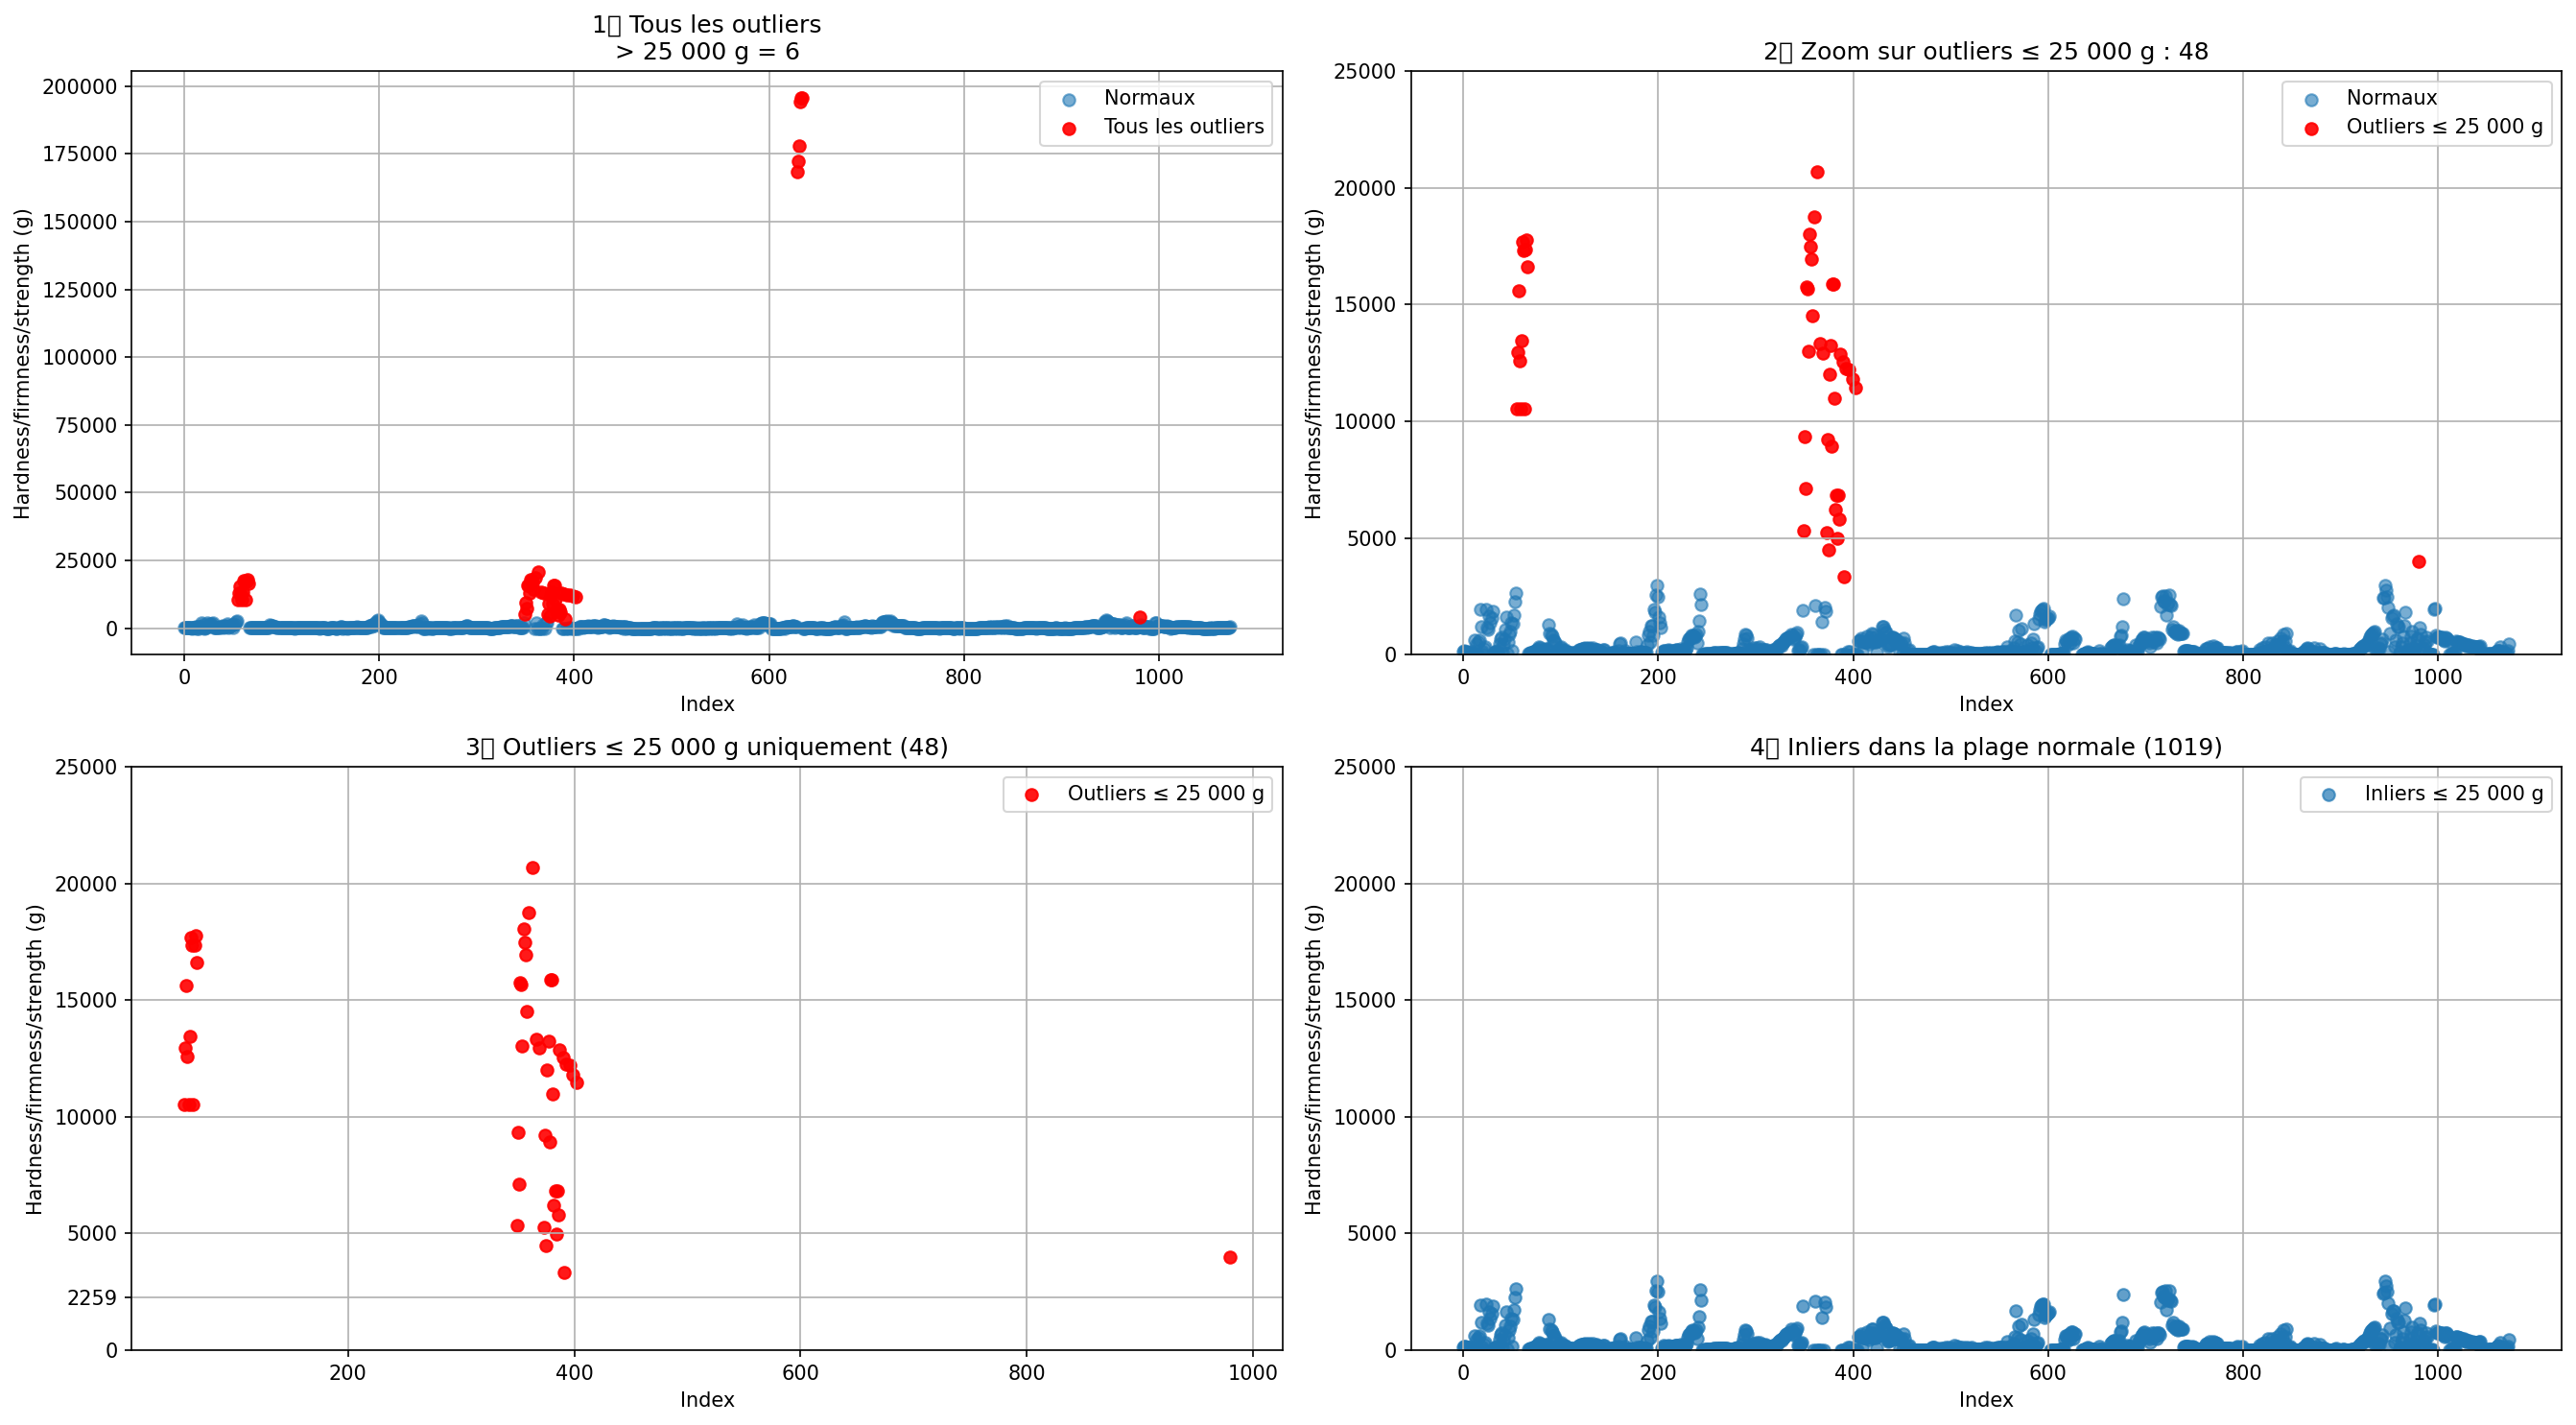

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Détection des outliers avec IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
df_cleaned['outlier'] = iso.fit_predict(df_cleaned[['Hardness/firmness/strength (g)']])

# 2. Séparation des groupes
outliers = df_cleaned[df_cleaned['outlier'] == -1]
inliers = df_cleaned[df_cleaned['outlier'] != -1]

outliers_gt_25000 = outliers[outliers['Hardness/firmness/strength (g)'] > 25000]
outliers_leq_25000 = outliers[outliers['Hardness/firmness/strength (g)'] <= 25000]
inliers_leq_25000 = inliers[inliers['Hardness/firmness/strength (g)'] <= 25000]

# 3. Création du subplot 2x2
fig, axes = plt.subplots(2, 2, figsize=(18, 10), dpi=150)

# --- [0, 0] Tous les inliers + tous les outliers
axes[0, 0].scatter(inliers.index,
                   inliers['Hardness/firmness/strength (g)'],
                   label='Normaux', alpha=0.6)
axes[0, 0].scatter(outliers.index,
                   outliers['Hardness/firmness/strength (g)'],
                   color='red', label='Tous les outliers', alpha=0.9)
axes[0, 0].set_title(f"1️⃣ Tous les outliers\n> 25 000 g = {len(outliers_gt_25000)}")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Hardness/firmness/strength (g)")
axes[0, 0].legend()
axes[0, 0].grid(True)

# --- [0, 1] Tous les inliers + seulement outliers ≤ 25 000
axes[0, 1].scatter(inliers.index,
                   inliers['Hardness/firmness/strength (g)'],
                   label='Normaux', alpha=0.6)
axes[0, 1].scatter(outliers_leq_25000.index,
                   outliers_leq_25000['Hardness/firmness/strength (g)'],
                   color='red', label='Outliers ≤ 25 000 g', alpha=0.9)
axes[0, 1].set_ylim(0, 25000)
axes[0, 1].set_title(f"2️⃣ Zoom sur outliers ≤ 25 000 g : {len(outliers_leq_25000)}")
axes[0, 1].set_xlabel("Index")
axes[0, 1].set_ylabel("Hardness/firmness/strength (g)")
axes[0, 1].legend()
axes[0, 1].grid(True)


# --- [1, 0] Outliers ≤ 25 000 g uniquement avec marge et valeur de début affichée
y_values = outliers_leq_25000['Hardness/firmness/strength (g)']
y_min = y_values.min()
marge = 0.05 * (25000 - y_min)  # 5% de marge visuelle
y_axis_min = y_min - marge

axes[1, 0].scatter(outliers_leq_25000.index,
                   y_values,
                   color='red', label='Outliers ≤ 25 000 g', alpha=0.9)

axes[1, 0].set_ylim(y_axis_min, 25000)
axes[1, 0].set_title(f"3️⃣ Outliers ≤ 25 000 g uniquement ({len(outliers_leq_25000)})")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Hardness/firmness/strength (g)")
axes[1, 0].legend()
axes[1, 0].grid(True)

# 🔢 Ajoute explicitement la graduation du bas avec sa valeur
yticks = axes[1, 0].get_yticks().tolist()
if y_axis_min not in yticks:
    yticks.insert(0, round(y_axis_min))  # ou round(y_axis_min, 1) si tu veux plus de précision
axes[1, 0].set_yticks(yticks)





# --- [1, 1] Seulement inliers dans plage normale (≤ 25 000)
axes[1, 1].scatter(inliers_leq_25000.index,
                   inliers_leq_25000['Hardness/firmness/strength (g)'],
                   label='Inliers ≤ 25 000 g', alpha=0.7)
axes[1, 1].set_ylim(0, 25000)
axes[1, 1].set_title(f"4️⃣ Inliers dans la plage normale ({len(inliers_leq_25000)})")
axes[1, 1].set_xlabel("Index")
axes[1, 1].set_ylabel("Hardness/firmness/strength (g)")
axes[1, 1].legend()
axes[1, 1].grid(True)

# Affichage propre
plt.tight_layout()
plt.show()


In [48]:
# --- 1. Données du graphe 4 : inliers ≤ 25 000 g
df_no_outliers = inliers[inliers['Hardness/firmness/strength (g)'] <= 25000].copy()
df_no_outliers.drop(columns='outlier', inplace=True)

print("Shape du DataFrame sans outliers (graphe 4) :", df_no_outliers.shape)
display(df_no_outliers.head())

# --- 2. Données du graphe 3 : outliers ≤ 25 000 g
df_outliers_soft = outliers[outliers['Hardness/firmness/strength (g)'] <= 25000].copy()
df_outliers_soft.drop(columns='outlier', inplace=True)

print("Shape du DataFrame des outliers doux (graphe 3) :", df_outliers_soft.shape)
display(df_outliers_soft.head())

# --- 3. Fusion des deux DataFrames
df_combined_soft_zone = pd.concat([df_no_outliers, df_outliers_soft], axis=0).sort_index()

print("Shape du DataFrame final combiné (inliers + outliers ≤ 25 000 g) :", df_combined_soft_zone.shape)
display(df_combined_soft_zone.head())


Shape du DataFrame sans outliers (graphe 4) : (1019, 18)


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),Hardness/firmness/strength (g)
0,10501,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,131.91
1,10501,12.00,NaN,NaN,NaN,NaN,NaN,80203.00,0.50,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,155.91
2,10501,12.00,NaN,NaN,NaN,NaN,NaN,80203.00,1.00,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,151.14
3,10501,12.00,NaN,NaN,NaN,NaN,NaN,80203.00,2.00,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,144.84
4,10501,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,NaN,NaN,90.00,30.00,4.00,12.00,1,95.71


Shape du DataFrame des outliers doux (graphe 3) : (48, 18)


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),Hardness/firmness/strength (g)
55,30304,25.00,30202.00,30201.00,0.10,20.00,5.00,NaN,NaN,6.60,NaN,NaN,70.00,15.00,8.00,NaN,1,10520.24
56,30304,25.00,30202.00,30201.00,250.00,20.00,5.00,NaN,NaN,6.60,NaN,NaN,70.00,15.00,8.00,NaN,1,12953.25
57,30304,25.00,30202.00,30201.00,300.00,20.00,5.00,NaN,NaN,6.60,NaN,NaN,70.00,15.00,8.00,NaN,1,15610.59
58,30304,25.00,30202.00,30201.00,350.00,20.00,5.00,NaN,NaN,6.60,NaN,NaN,70.00,15.00,8.00,NaN,1,12594.31
59,30304,25.00,30202.00,30201.00,0.10,20.00,10.00,NaN,NaN,6.60,NaN,NaN,70.00,15.00,8.00,NaN,1,10520.24


Shape du DataFrame final combiné (inliers + outliers ≤ 25 000 g) : (1067, 18)


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),Hardness/firmness/strength (g)
0,10501,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,131.91
1,10501,12.00,NaN,NaN,NaN,NaN,NaN,80203.00,0.50,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,155.91
2,10501,12.00,NaN,NaN,NaN,NaN,NaN,80203.00,1.00,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,151.14
3,10501,12.00,NaN,NaN,NaN,NaN,NaN,80203.00,2.00,5.00,NaN,NaN,90.00,30.00,4.00,12.00,1,144.84
4,10501,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,NaN,NaN,90.00,30.00,4.00,12.00,1,95.71


## Replace outliers data

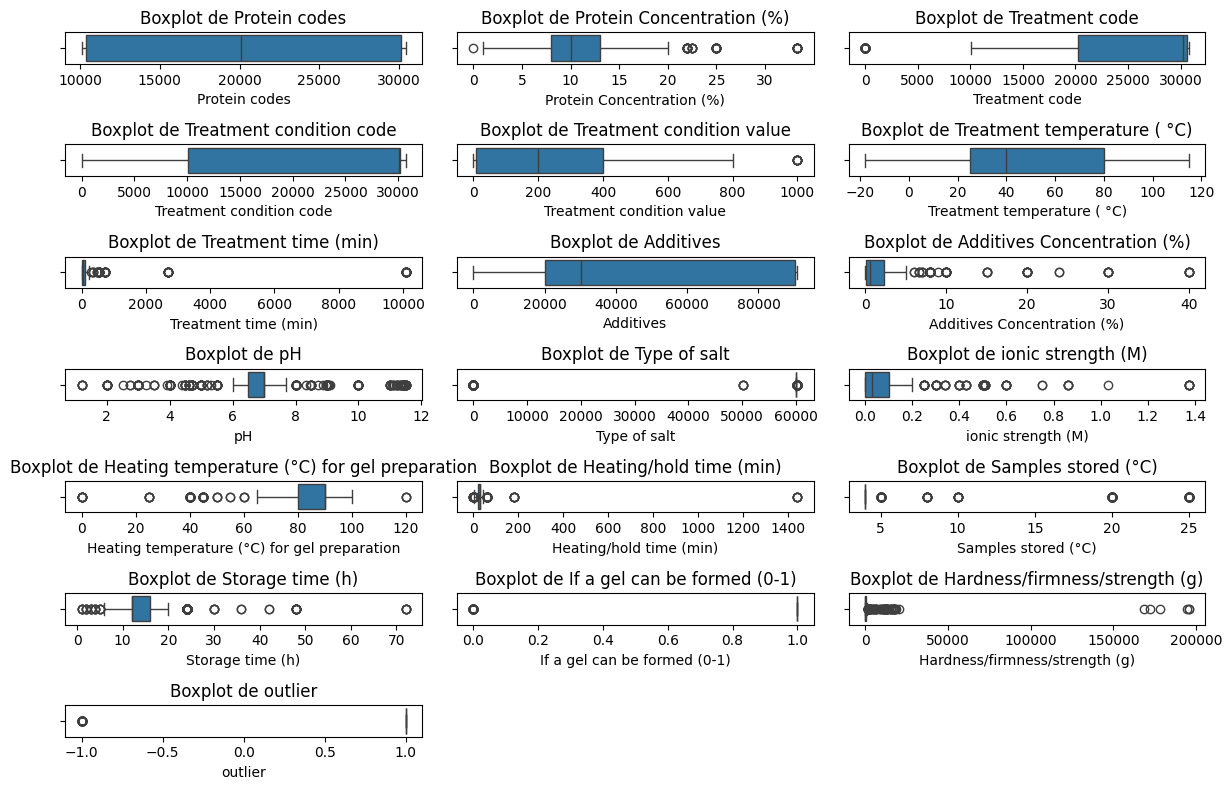

In [ ]:
'''import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(df):
    """
    Affiche des boxplots pour toutes les colonnes numériques du DataFrame.
    
    Args:
    - df : DataFrame contenant les données à analyser.
    """
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialiser la figure
    plt.figure(figsize=(12, 8))
    
    # Créer un boxplot pour chaque colonne numérique
    for i, col in enumerate(numeric_cols):
        plt.subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
    
    plt.tight_layout()  # Ajuster l'espacement entre les subplots
    plt.show()

# Exemple d'utilisation :
plot_boxplots(df_cleaned)'''


In [ ]:
'''import numpy as np

def replace_outliers_with_mean(df):
    """
    Remplace les outliers dans chaque colonne numérique par la moyenne de cette colonne,
    sauf pour la colonne pH.
    Un outlier est défini comme une valeur en dehors de [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR].
    
    Args:
    - df : DataFrame contenant les données à analyser.
    
    Returns:
    - DataFrame avec les outliers remplacés par la moyenne.
    """
    # Sélectionner uniquement les colonnes numériques sauf pH
    numeric_cols = df.select_dtypes(include=['number']).columns
    numeric_cols = [col for col in numeric_cols if col != 'pH']  # Exclure la colonne pH
    
    for col in numeric_cols:
        # Calculer les quartiles Q1 et Q3, ainsi que l'IQR (écart interquartile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Définir les limites pour les outliers
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        # Remplacer les outliers par la moyenne de la colonne
        mean_value = df[col].mean()
        df[col] = df[col].apply(lambda x: mean_value if x < lower_limit or x > upper_limit else x)
        
    return df

# Exemple d'utilisation :
df = replace_outliers_with_mean(df_cleaned)'''


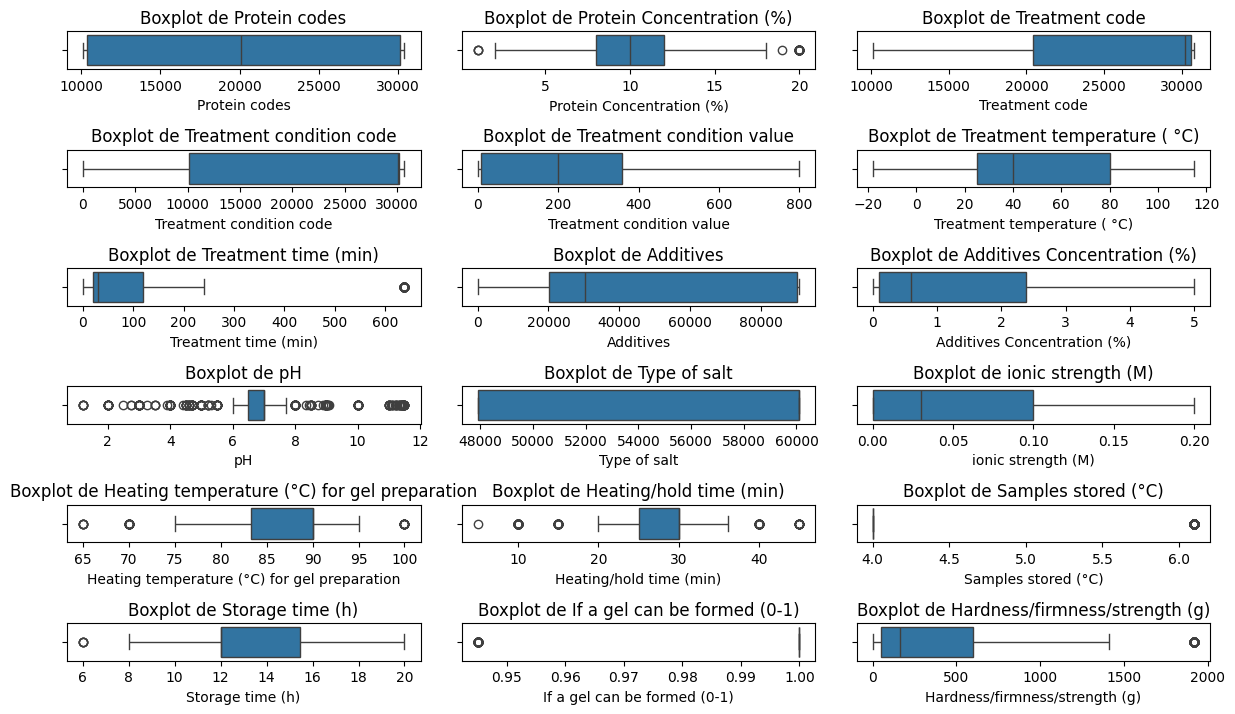

In [ ]:
'''import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(df):
    """
    Affiche des boxplots pour toutes les colonnes numériques du DataFrame.
    
    Args:
    - df : DataFrame contenant les données à analyser.
    """
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialiser la figure
    plt.figure(figsize=(12, 8))
    
    # Créer un boxplot pour chaque colonne numérique
    for i, col in enumerate(numeric_cols):
        plt.subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
    
    plt.tight_layout()  # Ajuster l'espacement entre les subplots
    plt.show()

# Exemple d'utilisation :
plot_boxplots(df)'''


In [49]:
df_combined_soft_zone.isna().sum()

Protein codes                                     0
Protein Concentration (%)                         0
Treatment code                                  393
Treatment condition code                        780
Treatment condition value                       822
Treatment temperature ( °C)                     652
Treatment time (min)                            523
Additives                                       387
Additives Concentration (%)                     410
pH                                              201
Type of salt                                    514
ionic strength (M)                              514
Heating temperature (°C) for gel preparation    169
Heating/hold time (min)                         169
Samples stored (°C)                             105
Storage time (h)                                229
If a gel can be formed (0-1)                      0
Hardness/firmness/strength (g)                    0
dtype: int64

## Imputation with KNN

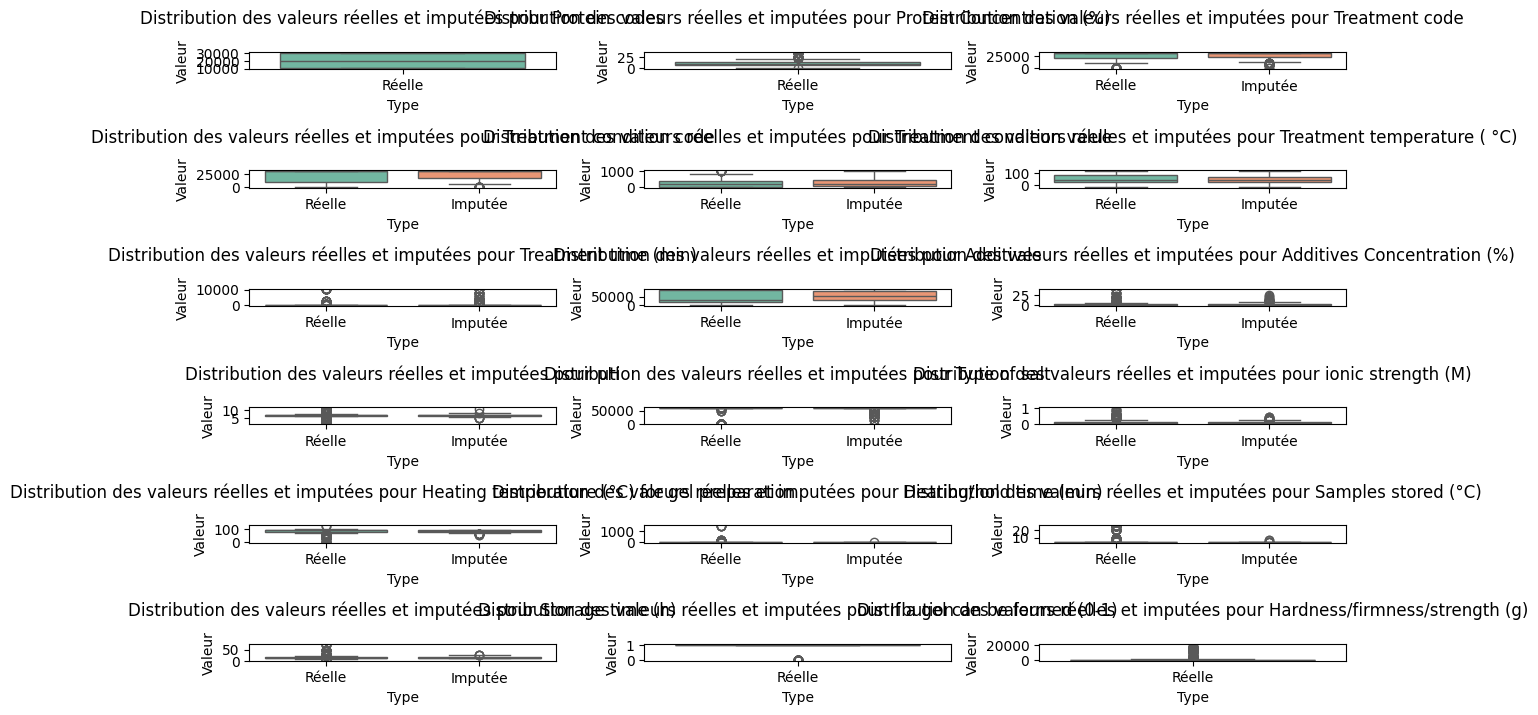

In [50]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

def knn_imputation_and_evaluation(df):
    """
    Effectue l'imputation KNN sur les colonnes numériques du DataFrame, puis compare
    les distributions des valeurs réelles et des valeurs imputées.
    
    Args:
    - df : DataFrame contenant les données à traiter.
    
    Retourne:
    - df_imputed : DataFrame avec les valeurs imputées.
    """
    # Sélectionner les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Créer un masque pour les valeurs manquantes
    nan_mask = df[numeric_cols].isna()
    
    # Appliquer l'imputation KNN
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = df.copy()
    
    # Appliquer l'imputation sur les colonnes numériques uniquement
    df_imputed[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    # Comparer les distributions des valeurs réelles et des valeurs imputées
    # Visualisation avec des boxplots pour chaque colonne
    fig = plt.figure(figsize=(12, 8))
    
    for i, col in enumerate(numeric_cols):
        ax = fig.add_subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        
        # Réinitialiser les index pour éviter les duplications après concaténation
        real_values = df[col].dropna().reset_index(drop=True)
        imputed_values = df_imputed.loc[nan_mask[col], col].reset_index(drop=True)
        
        # Combiner les valeurs réelles et imputées pour chaque colonne
        data = pd.DataFrame({
            'Valeur': pd.concat([real_values, imputed_values], ignore_index=True),
            'Type': ['Réelle'] * len(real_values) + ['Imputée'] * len(imputed_values)
        })
        
        # Plot des valeurs réelles et imputées avec un "hue" pour différencier
        sns.boxplot(x='Type', y='Valeur', data=data, palette="Set2", ax=ax)
        
        ax.set_title(f'Distribution des valeurs réelles et imputées pour {col}', fontsize=12, pad=20)
    
    # Ajuster les marges autour de l'ensemble de la figure pour les titres
    plt.subplots_adjust(hspace=0.6, top=0.9)  # Espacement entre les sous-figures et ajustement de la marge en haut
    plt.tight_layout()
    plt.show()
    
    return df_imputed

# Exemple d'utilisation :
df_imputed = knn_imputation_and_evaluation(df_combined_soft_zone)


In [ ]:
'''def save_missing_and_imputed(original_df, imputed_df):
    """
    Sauvegarde les lignes avec des valeurs manquantes et les lignes après imputation 
    dans deux fichiers Excel distincts.
    
    Args:
    - original_df : DataFrame avant imputation (avec valeurs manquantes).
    - imputed_df : DataFrame après imputation (valeurs imputées).
    """
    # Identifier les lignes avec des valeurs manquantes
    missing_rows = original_df[original_df.isna().any(axis=1)]
    
    # Sélectionner les mêmes lignes après imputation
    imputed_rows = imputed_df.loc[missing_rows.index]
    
    # Sauvegarder les deux DataFrames au format Excel
    missing_rows.to_excel("original_data_missingRow.xlsx", index=True)
    imputed_rows.to_excel("Imputation_data_ImputeRow.xlsx", index=True)
    
    print("✅ Les fichiers ont été sauvegardés :")
    print("- original_data_missingRow.xlsx (valeurs manquantes)")
    print("- Imputation_data_ImputeRow.xlsx (valeurs imputées)")
    
    return missing_rows, imputed_rows

# Exemple d'utilisation :
missing_rows, imputed_rows = save_missing_and_imputed(df, df_imputed)'''

✅ Les fichiers ont été sauvegardés :
- original_data_missingRow.xlsx (valeurs manquantes)
- Imputation_data_ImputeRow.xlsx (valeurs imputées)


In [51]:
df_imputed.isna().sum()

Protein codes                                   0
Protein Concentration (%)                       0
Treatment code                                  0
Treatment condition code                        0
Treatment condition value                       0
Treatment temperature ( °C)                     0
Treatment time (min)                            0
Additives                                       0
Additives Concentration (%)                     0
pH                                              0
Type of salt                                    0
ionic strength (M)                              0
Heating temperature (°C) for gel preparation    0
Heating/hold time (min)                         0
Samples stored (°C)                             0
Storage time (h)                                0
If a gel can be formed (0-1)                    0
Hardness/firmness/strength (g)                  0
dtype: int64

In [52]:
# Afficher les lignes dupliquées
duplicated_rows = df_imputed[df_imputed.duplicated()]

# Afficher le nombre de lignes dupliquées
print(f"Nombre de lignes dupliquées: {duplicated_rows.shape[0]}")

# Afficher les lignes dupliquées
duplicated_rows


Nombre de lignes dupliquées: 0


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),Hardness/firmness/strength (g)


In [53]:
df_imputed.drop_duplicates(inplace=True)

## Univariate analysis on (Hardness/firmness/strength)

In [54]:
df_imputed["Hardness/firmness/strength (g)"].unique()

array([1.319100e+02, 1.559100e+02, 1.511400e+02, 1.448400e+02,
       9.571000e+01, 1.074300e+02, 1.094500e+02, 1.186600e+02,
       2.945000e+01, 4.634000e+01, 5.838000e+01, 9.765000e+01,
       6.064800e+02, 0.000000e+00, 4.617800e+02, 5.459500e+02,
       6.220500e+02, 1.930950e+03, 1.202440e+03, 1.259500e+02,
       2.518200e+02, 3.195600e+02, 1.957820e+03, 1.172660e+03,
       1.091080e+03, 1.651910e+03, 1.356200e+03, 1.560140e+03,
       1.876250e+03, 7.760000e+01, 9.544000e+01, 1.427600e+02,
       1.835500e+02, 6.006000e+01, 7.240000e+01, 4.741600e+02,
       6.811600e+02, 7.607000e+02, 1.119600e+02, 4.262300e+02,
       6.577100e+02, 1.080880e+03, 1.630500e+03, 5.149000e+01,
       5.384000e+02, 8.545100e+02, 1.016640e+03, 1.375580e+03,
       1.692700e+02, 1.309290e+03, 1.714120e+03, 2.269850e+03,
       2.644080e+03, 1.052024e+04, 1.295325e+04, 1.561059e+04,
       1.259431e+04, 1.346208e+04, 1.769078e+04, 1.733796e+04,
       1.737773e+04, 1.776113e+04, 1.663335e+04, 5.3020

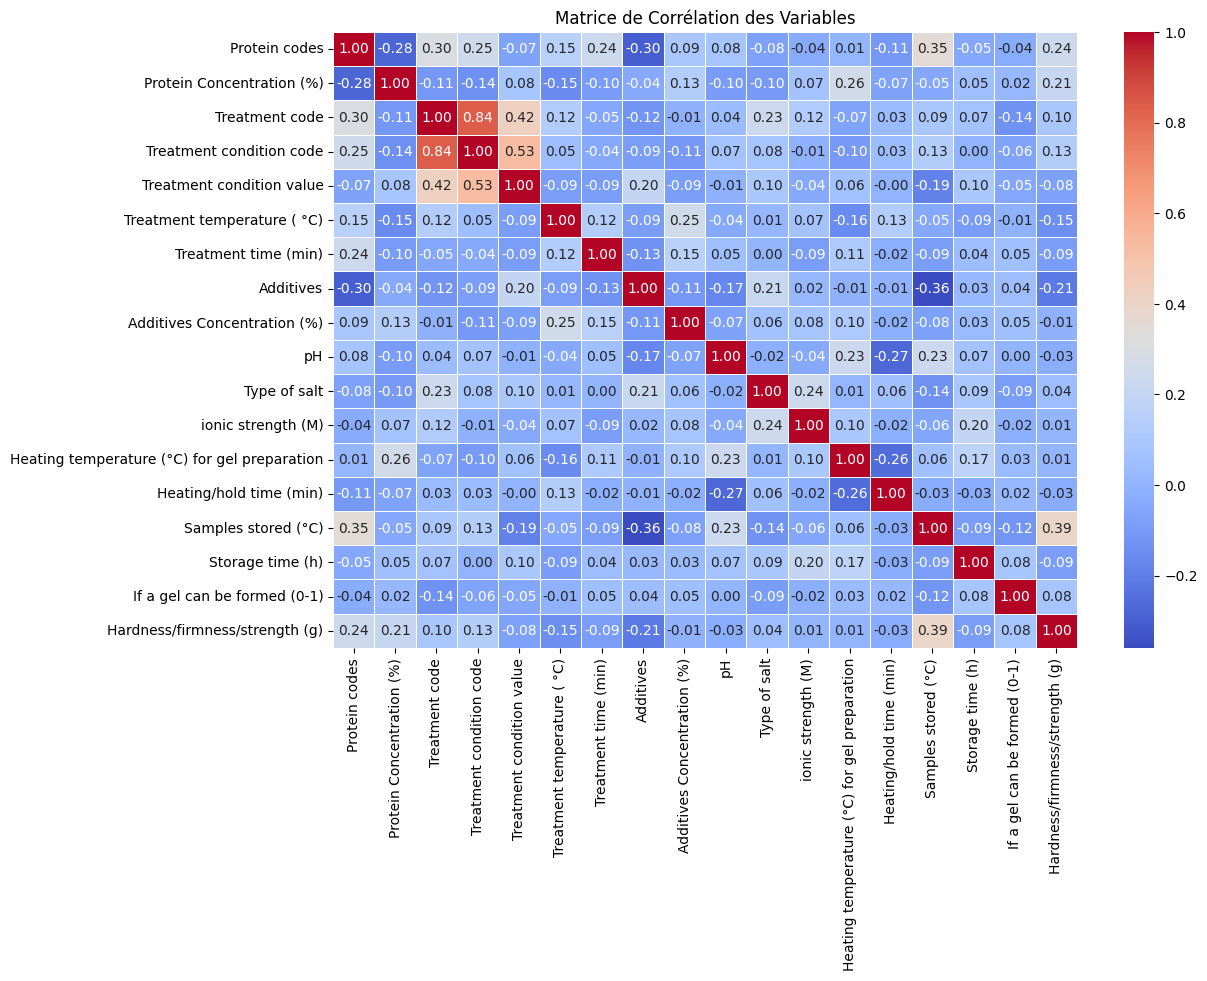

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définition de la figure
plt.figure(figsize=(12, 8))

# Heatmap avec annotations et une palette de couleurs contrastée
sns.heatmap(df_imputed.select_dtypes(include="number").corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Ajout d'un titre
plt.title("Matrice de Corrélation des Variables")

# Affichage du graphique
plt.show()

**Correlation of Pearson**

In [16]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(df_imputed["Hardness/firmness/strength (g)"], df_imputed["Samples stored (°C)"])
print(f"Corrélation de Pearson : {corr:.2f}, p-value : {p_value:.5f}")

Corrélation de Pearson : 0.39, p-value : 0.00000


<Axes: >

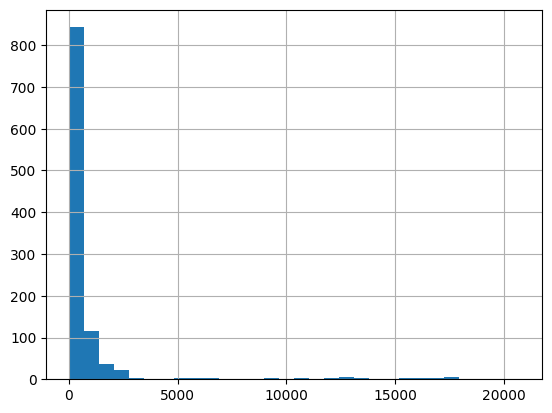

In [55]:
df_imputed["Hardness/firmness/strength (g)"].hist(bins=30)

## 2 - features engineering

In [57]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer

# ----------------------------
# Étape 1 - Séparation X / y
# ----------------------------
X = df_imputed.drop('Hardness/firmness/strength (g)', axis=1)
y = df_imputed['Hardness/firmness/strength (g)']

# ----------------------------
# Étape 2 - Transformation Yeo-Johnson (pas besoin d'offset)
# ----------------------------
pt = PowerTransformer(method='yeo-johnson')
y_transformed = pt.fit_transform(y.values.reshape(-1, 1)).flatten()

# Conversion en Series avec les mêmes index
y_transformed_series = pd.Series(y_transformed, index=y.index)

# ----------------------------
# Affichage résumé
# ----------------------------
print("✅ Transformation Yeo-Johnson appliquée à la cible.")
print("→ Shape :", y_transformed_series.shape)
print("→ Aperçu :")
display(y_transformed_series.head())


✅ Transformation Yeo-Johnson appliquée à la cible.
→ Shape : (1067,)
→ Aperçu :


0   -0.12
1   -0.04
2   -0.05
3   -0.07
4   -0.28
dtype: float64

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

# 1. Séparation X / y
X = df_combined_soft_zone.drop(columns='Hardness/firmness/strength (g)')
y = df_combined_soft_zone['Hardness/firmness/strength (g)']

# 2. Split train/test AVANT transformation de y
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Target encoding sur y_train_raw (valeurs originales)
categorical_cols = X_train.select_dtypes(include='object').columns

for col in categorical_cols:
    mean_encoding = y_train_raw.groupby(X_train[col]).mean()
    X_train[col] = X_train[col].map(mean_encoding)
    X_test[col] = X_test[col].map(mean_encoding)

    global_mean = y_train_raw.mean()
    X_train[col].fillna(global_mean, inplace=True)
    X_test[col].fillna(global_mean, inplace=True)

    print(f"Target encoding appliqué à : {col}")

# 4. Transformation Yeo-Johnson (sur y_train/y_test)
pt = PowerTransformer(method='yeo-johnson', standardize=True)
y_train = pt.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
y_test = pt.transform(y_test_raw.values.reshape(-1, 1)).ravel()

# 5. Affichage
print("\nX_train encodé (target encoded), y transformé (Yeo-Johnson) :")
display(X_train.head())



X_train encodé (target encoded), y transformé (Yeo-Johnson) :


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1)
333,10301,12.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,7.0,60101.0,0.2000,95.0,35.0,4.0,NaN,1
106,10301,7.0,30601.0,NaN,NaN,90.0,15.0,20108.0,0.5,NaN,60105.0,0.0257,90.0,15.0,4.0,12.0,1
585,10301,15.0,10101.0,10103.0,114.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,40.0,60.0,4.0,12.0,1
55,30304,25.0,30202.0,30201.0,0.1,20.0,5.0,NaN,NaN,6.6,NaN,NaN,70.0,15.0,8.0,NaN,1
213,10301,14.0,0.0,NaN,NaN,NaN,NaN,90402.0,0.2,NaN,60212.0,0.0049,90.0,30.0,4.0,24.0,1


## 3 - Train models

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb


# ----------------------------
# Séparation train/test
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_transformed_series, test_size=0.2, random_state=42
)

# ----------------------------
# Initialisation des modèles
# ----------------------------
models = {
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "LinearSVR": LinearSVR(random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42)
}


In [59]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 9. Entraînement et évaluation des modèles
results = []

for name, model in models.items():
    print(f"Entraînement du modèle : {name}")
    
    # Entraînement direct (pas de pipeline)
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Calcul des métriques
    metrics = {
        "R²": round(r2_score(y_test, y_pred) * 100, 2),  # en pourcentage
        "MAE": round(mean_absolute_error(y_test, y_pred), 2),
        "MSE": round(mean_squared_error(y_test, y_pred), 2),
        "RMSE": round(mean_squared_error(y_test, y_pred), 2)
    }
    
    results.append({"Modèle": name, **metrics})

# 10. Affichage des résultats
df_results = pd.DataFrame(results).sort_values(by="R²", ascending=False)
pd.set_option("display.float_format", "{:.2f}".format)
df_results


Entraînement du modèle : SGDRegressor
Entraînement du modèle : ElasticNet
Entraînement du modèle : GradientBoosting
Entraînement du modèle : AdaBoost
Entraînement du modèle : LinearSVR
Entraînement du modèle : KNeighbors
Entraînement du modèle : RandomForest
Entraînement du modèle : CatBoost
Entraînement du modèle : XGBoost
Entraînement du modèle : LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 853, number of used features: 17
[LightGBM] [Info] Start training from score -0.006708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Modèle,R²,MAE,MSE,RMSE
8,XGBoost,95.29,0.15,0.05,0.05
7,CatBoost,94.83,0.14,0.05,0.05
9,LightGBM,94.38,0.15,0.06,0.06
6,RandomForest,94.14,0.15,0.06,0.06
2,GradientBoosting,90.32,0.23,0.10,0.10
5,KNeighbors,77.06,0.30,0.24,0.24
3,AdaBoost,75.53,0.43,0.25,0.25
1,ElasticNet,35.10,0.63,0.67,0.67
4,LinearSVR,6.34,0.73,0.97,0.97
0,SGDRegressor,-1744019791361663998785237075464317566976.00,3811307325514229760.00,18022732613042733254584392159032508416.00,18022732613042733254584392159032508416.00


In [62]:
from catboost import CatBoostRegressor

# Initialisation du modèle
model = XGBRegressor(n_estimators=100, random_state=42)

# Entraînement du modèle avec les features ET la cible
model.fit(X_train, y_train)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R² Score: 0.9546
Mean Absolute Error (MAE): 74.4666
Root Mean Squared Error (RMSE): 136.5962

In [1]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Model predictions on the test set
y_pred = model.predict(X_test)

# Performance metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print metrics
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Optimized scatter plot
plt.figure(figsize=(12, 8), dpi=300)

# Scatter plot with error-based color and size
scatter = sns.scatterplot(
    x=y_test,
    y=y_pred,
    hue=np.abs(y_test - y_pred),  # Color by absolute error
    palette='Blues',
    size=np.abs(y_test - y_pred),  # Size by error magnitude
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5,
    legend=False  # Hide the automatic color legend
)

# Ideal line: y = x
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="y = x")

# Linear regression line: y = ax + b
a, b = np.polyfit(y_test, y_pred, 1)
y_reg = a * np.array([min_val, max_val]) + b
plt.plot([min_val, max_val], y_reg, color='blue', linestyle='-', linewidth=2, label=f"y = {a:.2f}x + {b:.2f}")

# Optional: Annotate max error
'''
max_error_index = np.argmax(np.abs(y_test - y_pred))
plt.annotate(
    f"Max Error: {y_test.iloc[max_error_index]} → {y_pred[max_error_index]:.2f}",
    (y_test.iloc[max_error_index], y_pred[max_error_index]),
    textcoords="offset points",
    xytext=(30, 30),
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
    arrowprops=dict(arrowstyle="->", color='black', lw=1.5)
)
'''

# Axis limits
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Axis labels
plt.xlabel("Experimental Gel Hardness (g)", fontsize=18)
plt.ylabel("Predicted Gel Hardness (g)", fontsize=18)

# Tick label size
plt.tick_params(axis='both', labelsize=14)

# Legend for regression lines
plt.legend(fontsize=14, title="Regression Lines", title_fontsize=16, loc='upper left')

# Colorbar for error magnitude
norm = plt.Normalize(np.abs(y_test - y_pred).min(), np.abs(y_test - y_pred).max())
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
cbar.set_label("Error Magnitude (g)", fontsize=14)

# Grid
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Layout adjustment
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

## CROSS VALIDATION ON 5-KFOLD

In [969]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Définir la validation croisée (5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Appliquer la validation croisée avec R² comme métrique
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# Afficher les résultats
print(f"Scores de chaque fold: {scores}")
print(f"R² moyen: {np.mean(scores):.4f}")
print(f"Écart-type des scores: {np.std(scores):.4f}")


Scores de chaque fold: [0.88391199 0.92285695 0.92822879 0.94915837 0.83076713]
R² moyen: 0.9030
Écart-type des scores: 0.0418


In [970]:
y_test.shape

(214,)

In [973]:
import numpy as np
import pandas as pd

# 1. Inverse transformation (if needed)
y_test_original = pt.inverse_transform(y_test.values.reshape(-1, 1)).flatten() if pt else y_test
y_pred_original = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten() if pt else y_pred

# 2. Compute errors
absolute_error = np.abs(y_test_original - y_pred_original)
relative_error_pct = 100 * absolute_error / np.abs(y_test_original)

# 3. Smart fuzzy score combining relative and absolute logic
def hybrid_fuzzy_score(y_true, abs_err, rel_err_pct,
                       rel_threshold=10, rel_max=20,
                       abs_threshold=0.3, abs_max=1.0):
    if y_true >= 5:
        # Use relative error for larger values
        if rel_err_pct <= rel_threshold:
            return 1.0
        elif rel_err_pct >= rel_max:
            return 0.0
        else:
            return 1.0 - ((rel_err_pct - rel_threshold) / (rel_max - rel_threshold))
    else:
        # Use absolute error for small values
        if abs_err <= abs_threshold:
            return 1.0
        elif abs_err >= abs_max:
            return 0.0
        else:
            return 1.0 - ((abs_err - abs_threshold) / (abs_max - abs_threshold))

# 4. Apply hybrid fuzzy score
fuzzy_scores = [
    hybrid_fuzzy_score(y, ae, re)
    for y, ae, re in zip(y_test_original, absolute_error, relative_error_pct)
]

# 5. Build the full error DataFrame
df_errors = pd.DataFrame({
    'True value (y)': y_test_original,
    'Prediction (ŷ)': y_pred_original,
    'Absolute error': absolute_error,
    'Relative error (%)': relative_error_pct,
    'Fuzzy logic score (0 to 1)': fuzzy_scores
})

# 6. Classify predictions based on fuzzy score
df_errors['Prediction quality'] = df_errors['Fuzzy logic score (0 to 1)'].apply(
    lambda x: 'Good' if x > 0.5 else 'Bad'
)

# 7. Display smart classification
df_good = df_errors[df_errors['Prediction quality'] == 'Good']
df_bad = df_errors[df_errors['Prediction quality'] == 'Bad']

total = len(df_errors)
good_count = len(df_good)
bad_count = len(df_bad)

print(f"Good predictions (fuzzy logic): {good_count}/{total} "
      f"({round(100 * good_count / total, 2)}%)")
display(df_good)

print(f"\nBad predictions (fuzzy logic): {bad_count}/{total} "
      f"({round(100 * bad_count / total, 2)}%)")
display(df_bad)

# 8. Global fuzzy satisfaction score
mean_fuzzy_score = round(df_errors['Fuzzy logic score (0 to 1)'].mean(), 3)
print(f"\n📊 Global fuzzy score (mean): {mean_fuzzy_score}")


Good predictions (fuzzy logic): 102/214 (47.66%)


,True value (y),Prediction (ŷ),Absolute error,Relative error (%),Fuzzy logic score (0 to 1),Prediction quality
0,925.59,913.64,11.95,1.29,1.00,Good
1,1.00,1.20,0.20,19.79,1.00,Good
2,42.73,40.60,2.13,4.99,1.00,Good
4,536.71,486.77,49.94,9.30,1.00,Good
6,681.00,665.29,15.71,2.31,1.00,Good
...,...,...,...,...,...,...
206,233.49,231.77,1.72,0.74,1.00,Good
207,349.28,330.17,19.11,5.47,1.00,Good
208,99.55,95.57,3.98,3.99,1.00,Good
210,128.00,138.53,10.53,8.22,1.00,Good



Bad predictions (fuzzy logic): 112/214 (52.34%)


,True value (y),Prediction (ŷ),Absolute error,Relative error (%),Fuzzy logic score (0 to 1),Prediction quality
3,202.77,166.24,36.53,18.02,0.20,Bad
5,71.65,98.02,26.37,36.81,0.00,Bad
10,159.00,209.04,50.04,31.47,0.00,Bad
11,950.34,1297.90,347.56,36.57,0.00,Bad
14,76.00,37.82,38.18,50.24,0.00,Bad
...,...,...,...,...,...,...
201,21.56,70.34,48.78,226.21,0.00,Bad
204,41.79,193.51,151.72,363.06,0.00,Bad
209,269.00,157.07,111.93,41.61,0.00,Bad
211,21.73,16.62,5.11,23.50,0.00,Bad



📊 Global fuzzy score (mean): 0.478


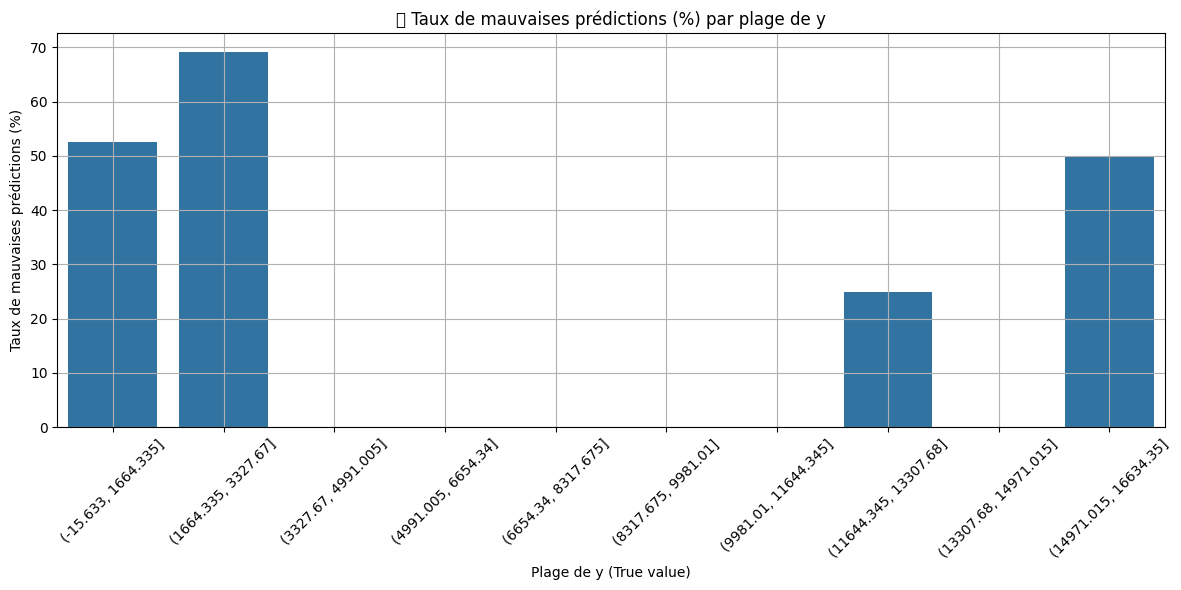

In [962]:
bad_rate_by_bin = df_errors.groupby('y_bin')['Prediction quality'].apply(
    lambda x: (x == 'Bad').mean() * 100
).reset_index(name='Bad Prediction Rate (%)')

# Graphe
plt.figure(figsize=(12, 6))
sns.barplot(data=bad_rate_by_bin, x='y_bin', y='Bad Prediction Rate (%)')
plt.xticks(rotation=45)
plt.title("❌ Taux de mauvaises prédictions (%) par plage de y")
plt.xlabel("Plage de y (True value)")
plt.ylabel("Taux de mauvaises prédictions (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


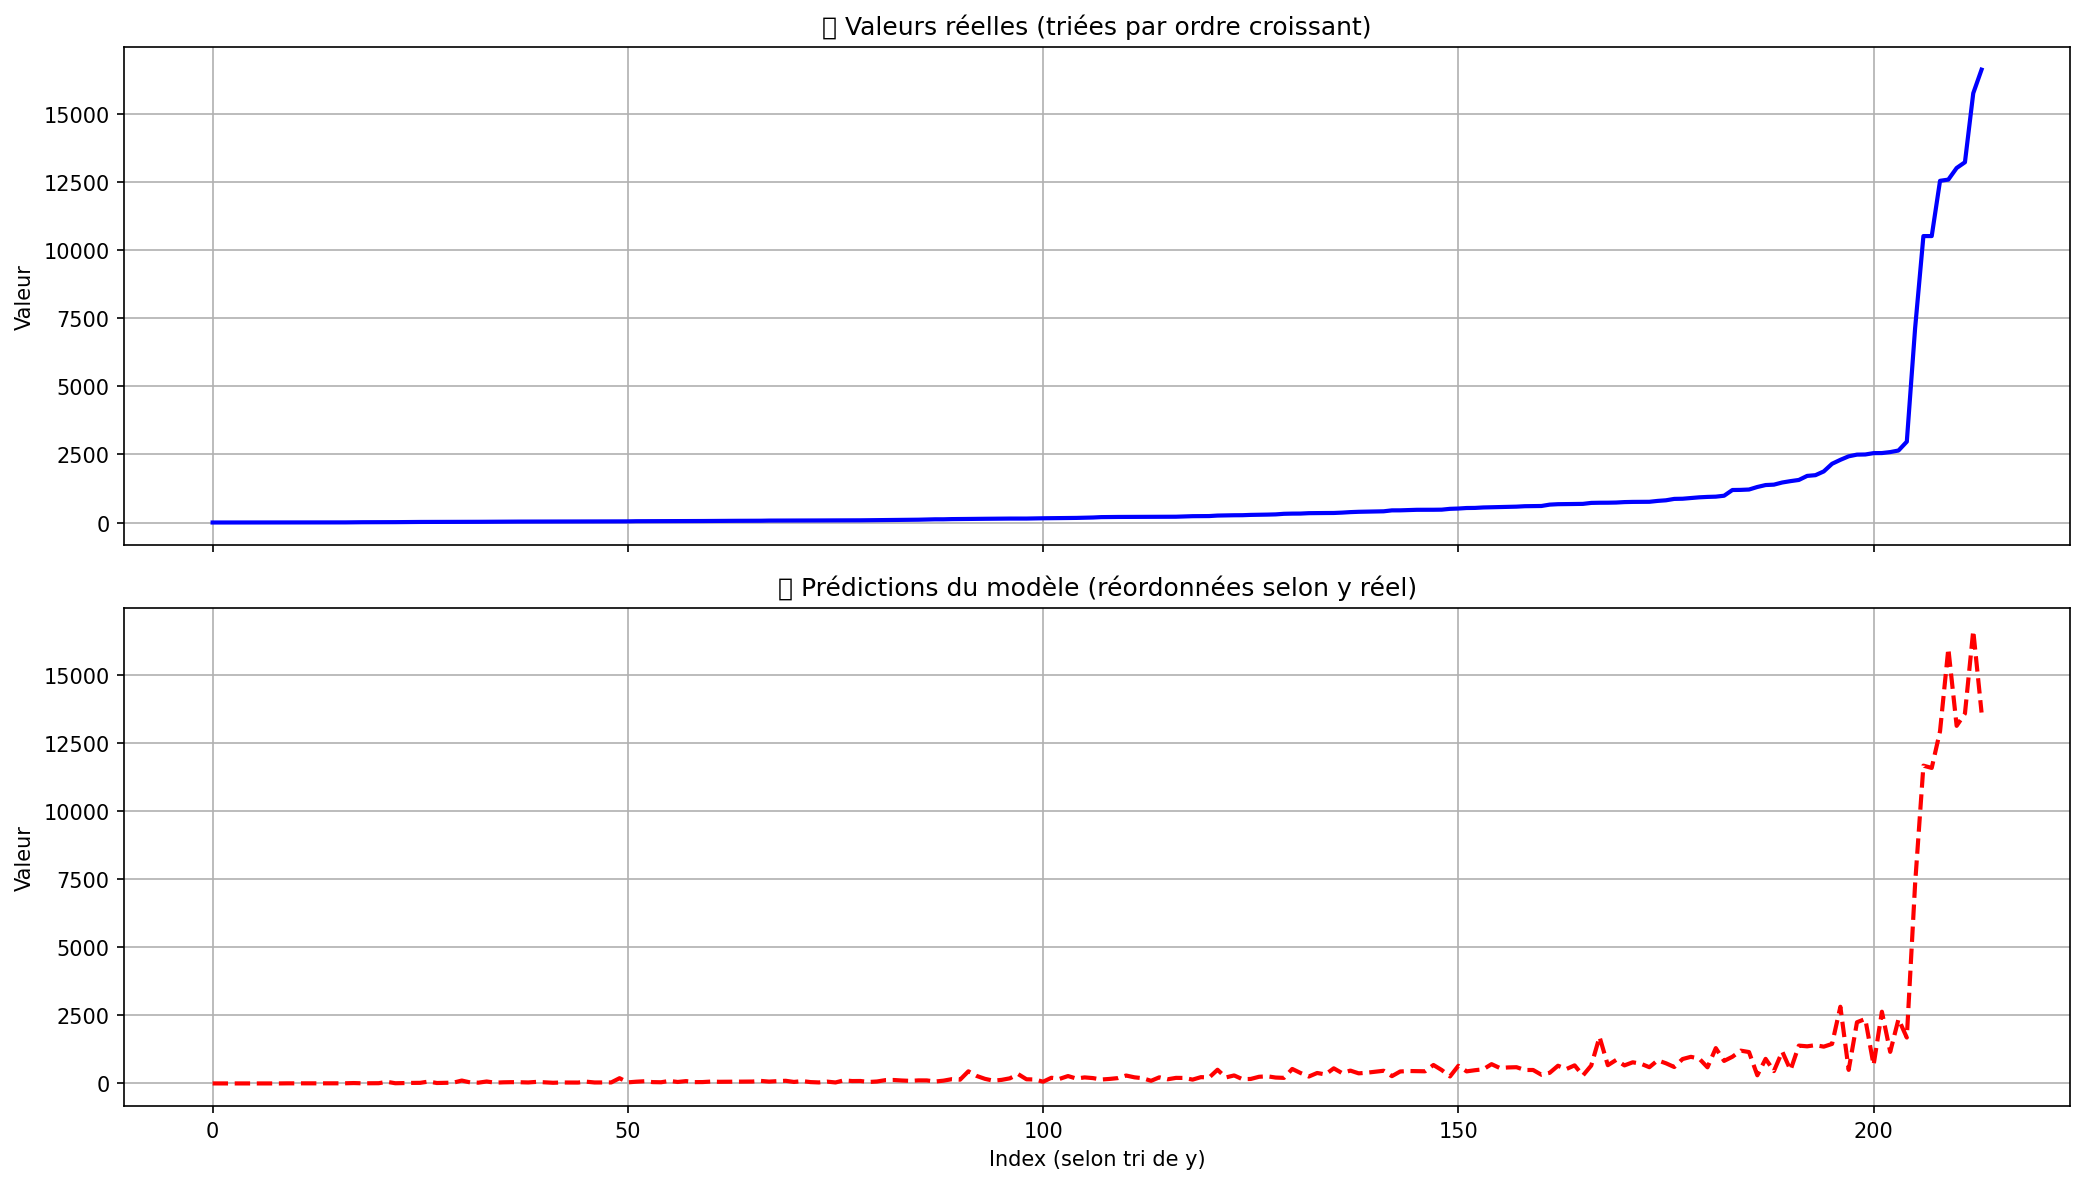

In [957]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Ordonner selon y_test_original
sorted_indices = np.argsort(y_test_original)
y_test_sorted = y_test_original[sorted_indices]
y_pred_sorted = y_pred_original[sorted_indices]

# 2. Subplot comparatif : valeurs réelles vs prédictions (même ordre)
fig, axes = plt.subplots(2, 1, figsize=(14, 8), dpi=150, sharex=True)

# Graphe 1 : Valeurs réelles triées
axes[0].plot(y_test_sorted, color='blue', linewidth=2)
axes[0].set_title("✅ Valeurs réelles (triées par ordre croissant)")
axes[0].set_ylabel("Valeur")
axes[0].grid(True)

# Graphe 2 : Prédictions dans le même ordre
axes[1].plot(y_pred_sorted, color='red', linewidth=2, linestyle='--')
axes[1].set_title("📊 Prédictions du modèle (réordonnées selon y réel)")
axes[1].set_xlabel("Index (selon tri de y)")
axes[1].set_ylabel("Valeur")
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Check the homoscedasticity of the residuals and the distribution of the residuals

✔ If the residuals (errors between prediction and true value) are randomly distributed around zero (without any obvious structure), this means that the homoscedasticity assumption is met.

❌ If a particular shape appears (e.g. open or closed cone), this indicates heteroscedasticity, which can distort predictions and require data transformation.

✔ If the residuals have a bell-shaped (Gaussian) distribution, then the normality hypothesis is respected.

❌ If the residuals are asymmetric or have extreme values ​​(thick tails), this may indicate the presence of outliers or the need for a data transformation (e.g. logarithmic).

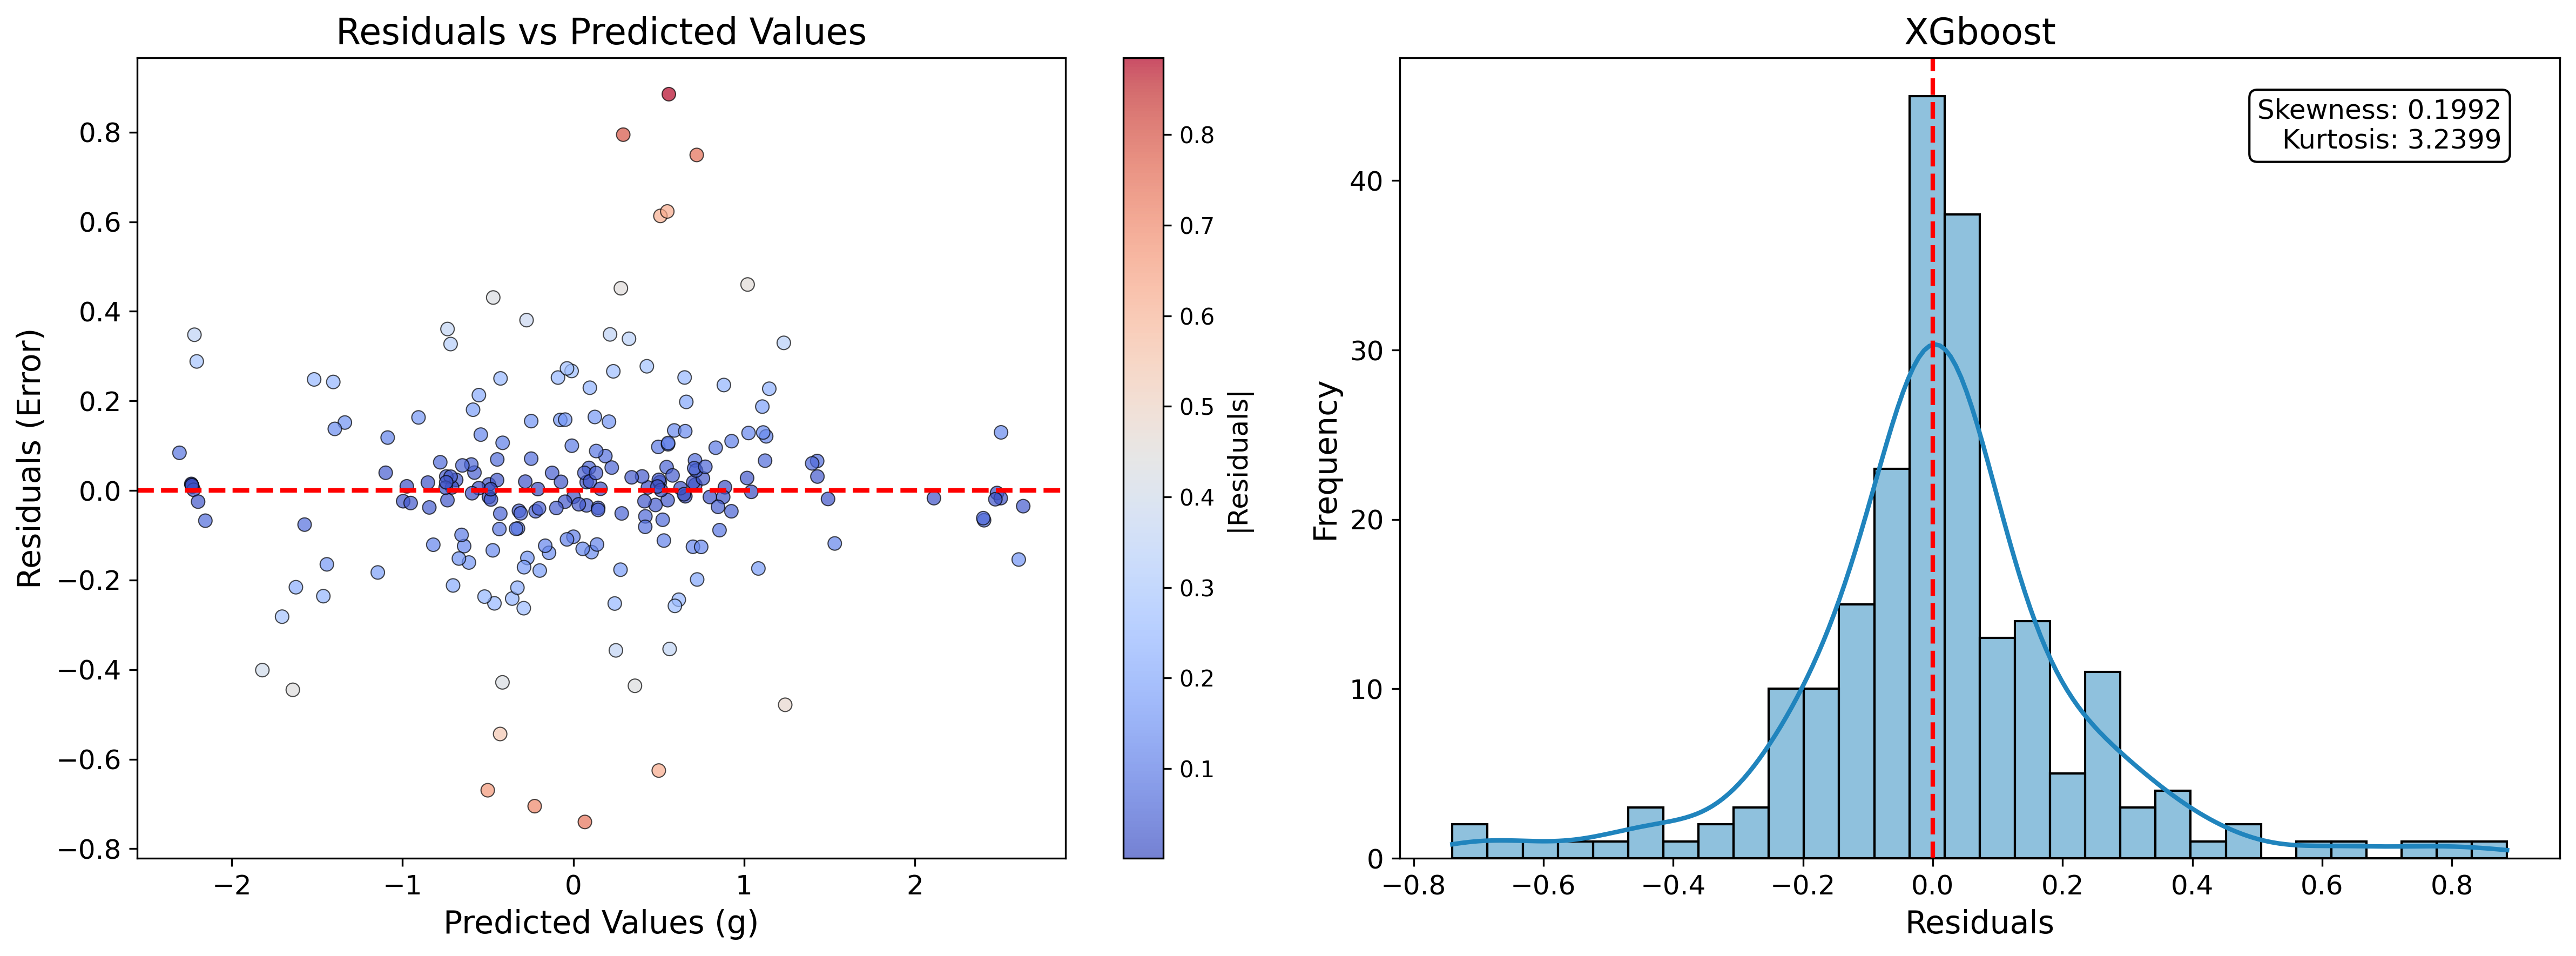

Skewness : 0.1992
Kurtosis : 3.2399


In [945]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Calculation of residuals
residuals = y_test - y_pred

# Creating a single figure with 2 sub-graphs
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# 1st Graph: Plot of residuals vs predicted values
scatter = axes[0].scatter(y_pred, residuals, c=np.abs(residuals), cmap="coolwarm", alpha=0.7, edgecolor="k", linewidth=0.5)
axes[0].axhline(y=0, color="red", linestyle="dashed", linewidth=2)  # Ligne horizontale à 0
axes[0].set_xlabel("Predicted Values (g)", fontsize=14)
axes[0].set_ylabel("Residuals (Error)", fontsize=14)
axes[0].set_title("Residuals vs Predicted Values", fontsize=16)
axes[0].tick_params(axis='both', labelsize=12)

# Adding a colorbar for better interpretation
cbar = fig.colorbar(scatter, ax=axes[0])
cbar.set_label("|Residuals|", fontsize=12)

# 2nd Graph: Histogram of residuals
sns.histplot(residuals, bins=30, kde=True, color="#2084bd", edgecolor="black", ax=axes[1], line_kws={'linewidth': 2})
axes[1].axvline(x=0, color='red', linestyle='dashed', linewidth=2)  # Ligne centrale
axes[1].set_title("XGboost", fontsize=16)
axes[1].set_xlabel("Residuals", fontsize=14)
axes[1].set_ylabel("Frequency", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)

# Adding skewness and kurtosis as annotations
axes[1].annotate(f"Skewness: {stats.skew(residuals):.4f}\nKurtosis: {stats.kurtosis(residuals):.4f}", 
                 xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=12, bbox=dict(boxstyle="round", fc="white", ec="black"))

# Display
plt.tight_layout()
plt.show()

print(f"Skewness : {stats.skew(residuals):.4f}")
print(f"Kurtosis : {stats.kurtosis(residuals):.4f}")


In [946]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Ajouter une constante aux variables explicatives
X = sm.add_constant(X_test)

# Exécuter le test de Breusch-Pagan
test = het_breuschpagan(residuals, X)
p_value = test[1]

# Affichage des résultats avec interprétation
print(f"Breusch-Pagan p-value: {p_value:.4f}")

if p_value < 0.05:
    print("🔴 Hétéroscédasticité détectée : La variance des résidus n'est pas constante.")
    print("📌 Il peut être nécessaire d'appliquer une transformation des données ou d'utiliser une régression robuste.")
else:
    print("🟢 Homoscédasticité confirmée : La variance des résidus est constante.")
    print("✅ Aucune correction nécessaire pour l’hétéroscédasticité.")


Breusch-Pagan p-value: 0.2760
🟢 Homoscédasticité confirmée : La variance des résidus est constante.
✅ Aucune correction nécessaire pour l’hétéroscédasticité.


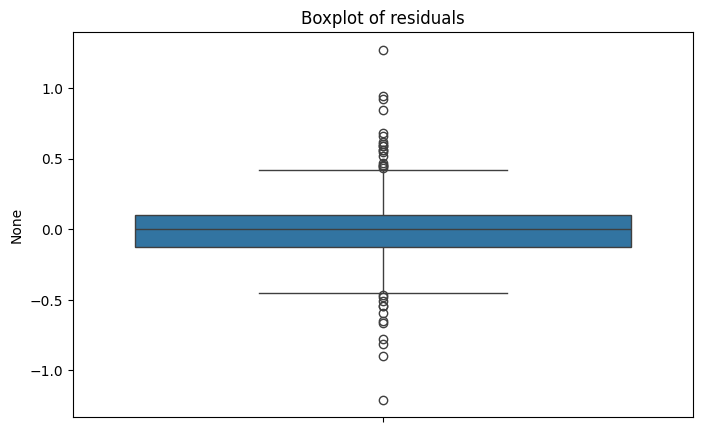

In [548]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(y=residuals)
plt.title("Boxplot of residuals")
plt.show()


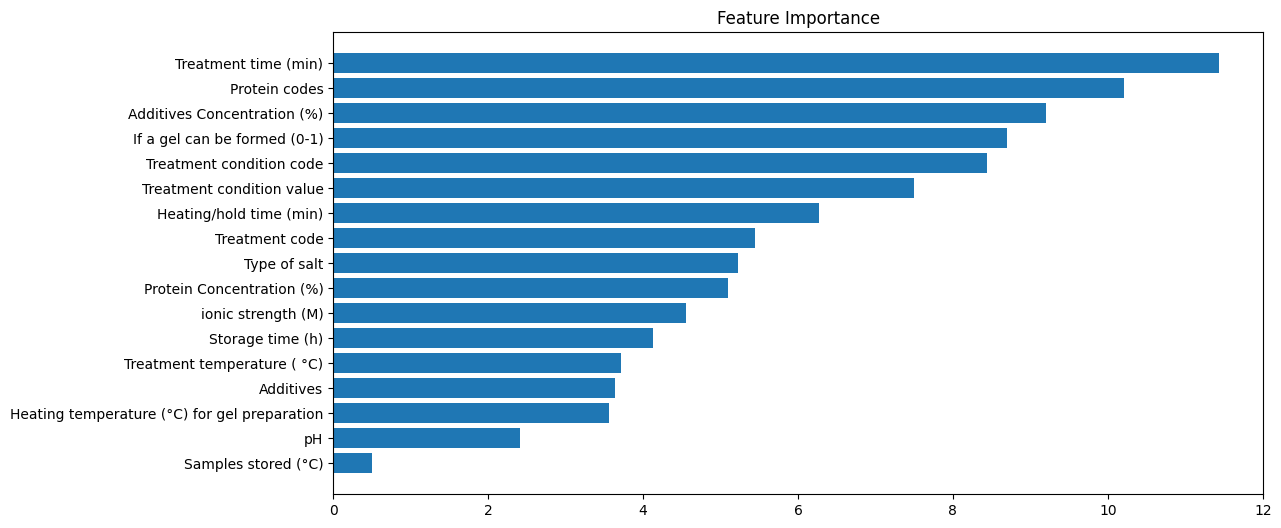

In [549]:
from matplotlib import pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

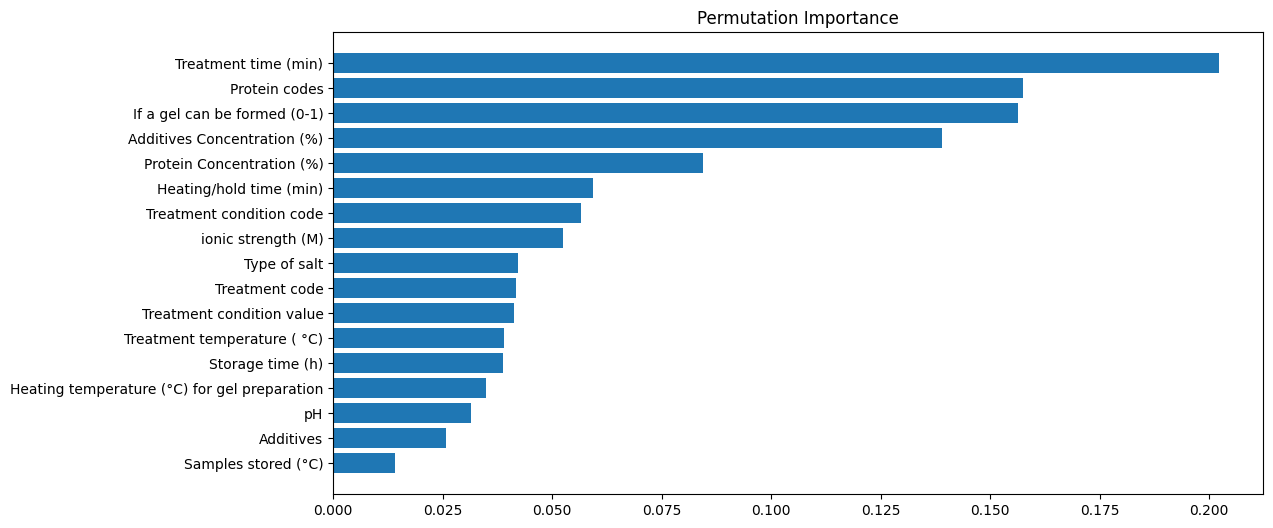

In [550]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')
plt.show()

### Explanation using SHAP values

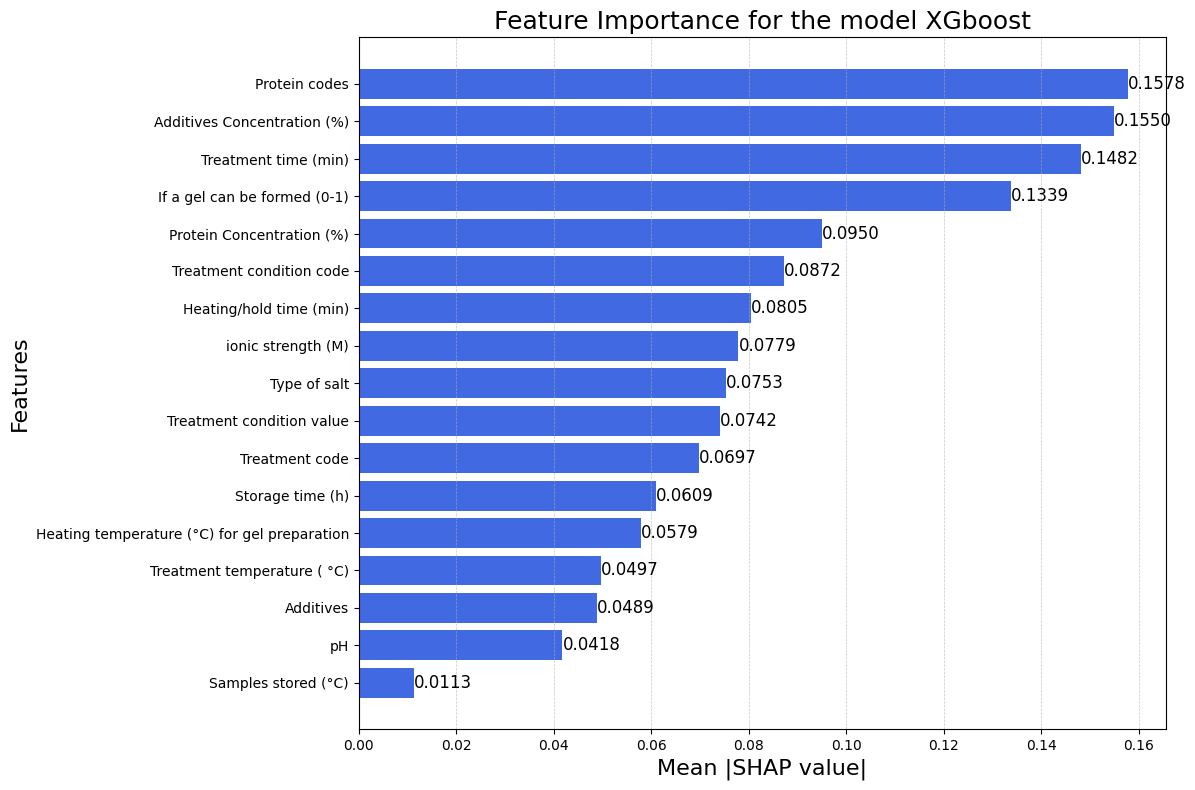

In [551]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Calcul des valeurs SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# Extraire les valeurs moyennes SHAP par caractéristique
shap_means = np.abs(shap_values.values).mean(axis=0)

# Trier les caractéristiques par importance
sorted_indices = np.argsort(shap_means)[::-1]

# Définir le nombre de caractéristiques à afficher
max_display = min(X_test.shape[1], 20)

# Préparer les données triées
sorted_shap_means = shap_means[sorted_indices][:max_display]
sorted_features = X_test.columns[sorted_indices][:max_display]

# Création du graphique en barres
plt.figure(figsize=(12, 8))

bars = plt.barh(sorted_features[::-1], sorted_shap_means[::-1], color='royalblue')

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, sorted_shap_means[::-1]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.4f}',
             ha='left', va='center', fontsize=12, color='black')

plt.xlabel("Mean |SHAP value|", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.title("Feature Importance for the model XGboost", fontsize=18)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

### Explanation for Technical Audience (Data Scientists):
This SHAP summary plot shows the average magnitude of SHAP values for features used in a **CatBoostRegressor model**. The SHAP value for each feature represents its contribution to the model's predictions. The features are ranked in descending order of importance based on their mean absolute SHAP values. 

- **"Ionic strength (M)"** has the highest importance, indicating it significantly impacts the model's predictions.
- Features like **"Samples stored (°C)"** and **"Type of salt"** also play crucial roles but are less influential compared to "Ionic strength."
- Features such as **"Additives"** and **"Protein codes"** have much smaller SHAP values, implying they contribute less to the prediction.

The results can guide feature engineering and domain understanding by highlighting which variables are driving the predictions.

---

### Explanation for Non-Technical Stakeholders:
This plot helps us understand which factors are most important for the predictions made by the model. Each bar represents how much a specific factor (like **"Ionic strength"** or **"Samples stored temperature"**) influences the model's outcomes on average.

- The top factor, **"Ionic strength"**, has the biggest influence, meaning it strongly affects how the predictions change.
- Factors like the **"storage temperature"** and the **"type of salt"** are also quite important, but less so than ionic strength.
- Factors lower down, like **"Additives"**, have very little impact on the model's predictions.

This information can help focus on the most critical factors for decision-making or further experimentation.

In [28]:
shap.initjs()
shap.plots.force(shap_values[0, ...])

In [30]:
shap.initjs()
shap.plots.force(shap_values[11, ...])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

### Using DiCE library for counterfactual explanations

In [40]:
import dice_ml
from dice_ml import Dice

d_gel = dice_ml.Data(dataframe=df_clean,
                      continuous_features=list(numerical_cols),
                      outcome_name='Hardness/firmness/strength (g)')

# We provide the type of model as a parameter (model_type)
catboost_with_preprocessing = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))])
catboost_with_preprocessing.fit(X_train, y_train)
m_gel = dice_ml.Model(model=catboost_with_preprocessing, backend="sklearn", model_type='regressor')
exp_genetic_gel = Dice(d_gel, m_gel, method="genetic")

In [32]:
import joblib
joblib.dump(Xg_boost_model, 'modelBoosting.joblib')

['modelBoosting.joblib']

In [33]:
import joblib
import numpy as np

# Charger le modèle
model = joblib.load(r"C:\Model_to_predict_GelHardness\Notebooks\modelBoosting.joblib")

# Exemple de données d'entrée
X_input = np.array([[
    50, 50.0, 5, 5, 50.0, 25, 5.0,
    1, 50.0, 7.0, 1, 0.5, 100, 60.0, 4,
    500, 0, 500.0
]])

# Prédiction
prediction = model.predict(X_input)

# Affichage du résultat
print(f"Prédiction du modèle : {prediction[0]:.2f}")


ValueError: Feature shape mismatch, expected: 17, got 18